In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import tqdm
import os
import time
import pickle
from tensorboardX import SummaryWriter

#from envs.burgers import Burgers
#from buffer import OfflineReplayBuffer
from critic import ValueLearner, QPiLearner, QSarsaLearner
from bppo import BehaviorCloning, BehaviorProximalPolicyOptimization
#from envs.burgers import Burgers

In [2]:
# Hyperparameters

# Experiment
env_name='burger'
path='logs'
log_freq=int(100)
seed=20241230
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# For Value
v_steps=int(50000)
v_hidden_dim = 512
v_depth = 3
v_lr = 1e-4
v_batch_size = 64

# For Q
q_bc_steps=int(50000)
q_pi_steps=10 # Number of steps to update Q-network in each iteration. Only used if is_offpolicy_update=True.
q_hidden_dim = 512
q_depth = 3
q_lr = 1e-4
q_batch_size = 64
target_update_freq=2
tau=0.005 # Soft update rate for target Q network parameters. See Q_learner.update()
gamma=0.99 # Discount factor for calculating the return.
is_offpolicy_update=False # Whether to use advantage replacement (as proposed in the BPPO paper) in Q-learning.
# If False, use Q-learning to update the Q-network parameters in each iteration.
# If True, only update the Q-network parameters once, and keep using this Q-network.

# For BC
bc_steps=int(50000)
bc_lr = 1e-4
bc_hidden_dim = 512
bc_depth = 3
bc_batch_size = 64

# For BPPO
bppo_steps=int(10000)
bppo_hidden_dim = 512
bppo_depth = 3
bppo_lr = 1e-4
bppo_batch_size = 64
clip_ratio=0.25 # PPO clip ratio. The probability ratio between new and old policy is clipped to be in the range [1-clip_ratio, 1+clip_ratio]
entropy_weight=0.00 # Weight of entropy loss in PPO and BPPO. Can be set to 0.01 for medium tasks.
decay=0.96 # Decay rate of PPO clip ratio
omega=0.9 # Related to setting the weight of advantage (see PPO code)
is_clip_decay=True # Whether to decay the clip_ratio during training
is_bppo_lr_decay=True # Whether to decay the learning rate of BPPO during trainining
is_update_old_policy=True # Whether to update the old policy of BPPO in each iteration. The old policy is used to calculate the probability ratio.
is_state_norm=False # Whether to normalize the states of the dataset.

# Other Settings
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device=torch.device('cpu')
state_dim = 128
action_dim = 128
x_range=(0,1)
nt=10000
dt=1e-4
nx=state_dim
dx=(x_range[1]-x_range[0])/nx
t_sample_interval=1000
nt1=nt//t_sample_interval

reward_ratio=0.1

In [3]:
from generate_burgers import load_burgers_data_sampled
from memory import ReplayMemory
'''
burgers_data_dict = load_burgers_data_sampled(
                x_range=x_range,
                nt = nt, # Number of time steps
                nx = state_dim, # Number of spatial nodes (grid points)
                dt= dt, # Temporal interval
                t_sample_interval=t_sample_interval, # The interval of time steps to generate a new control signal
                N = N, # Number of samples (trajectories) to generate
                )
'''
burgers_data_dict=pickle.load(open('data123\\burgers_2000_10_128_1735571539.pkl', 'rb'))
N=2000 # Number of trajectories to collect for offline dataset

print('Observations shape: ', burgers_data_dict['observations'].shape)
print('Next observations shape: ', burgers_data_dict['next_observations'].shape)
print('Actions shape: ', burgers_data_dict['actions'].shape)
print('Y_f shape: ', burgers_data_dict['Y_f'].shape)


state_trajectory=burgers_data_dict['observations'] # (N, nt1, state_dim)
action_trajectory=burgers_data_dict['actions'] # (N, nt1, action_dim)
final_state=burgers_data_dict['Y_f'] # (N, state_dim)
next_state_trajectory=burgers_data_dict['next_observations'] # (N, nt1, state_dim)

# Concatenate states, and compute rewards
concat_states=[]
concat_next_states=[]
rewards=[]
for n in range(N): # Loop over trajectories
    for t in range(nt1): # Loop over time steps
        concat_state = np.concatenate((state_trajectory[n, t], final_state[n], np.array([t])))
        concat_next_state = np.concatenate((next_state_trajectory[n, t], final_state[n], np.array([t])))
        state_reward = -((state_trajectory[n, t]-final_state[n])**2).mean()
        action_reward = -np.sum(action_trajectory[n, t]**2)
        reward = state_reward + reward_ratio*action_reward
        concat_states.append(concat_state)
        concat_next_states.append(concat_next_state)
        rewards.append(reward)
concat_states=np.array(concat_states) # (N*nt1, state_dim*2+1)
concat_next_states=np.array(concat_next_states) # (N*nt1, state_dim*2+1)
rewards=np.array(rewards) # (N*nt1,)
print('Concatenated states shape: ', concat_states.shape)
print('rewards shape: ', rewards.shape)

memory_data_dict={}
memory_data_dict['observations']=torch.tensor(concat_states, dtype=torch.float32)
memory_data_dict['actions']=torch.tensor(action_trajectory, dtype=torch.float32).reshape(N*nt1, action_dim)
memory_data_dict['rewards']=torch.tensor(rewards, dtype=torch.float32)
memory_data_dict['next_observations']=torch.tensor(concat_next_states, dtype=torch.float32)
memory_data_dict['timeouts']=torch.zeros(N*nt1, dtype=torch.int) # Placeholder, not used
memory_data_dict['terminals']=torch.zeros(N*nt1, dtype=torch.int) # Placeholder, not used

memory = ReplayMemory(max_size=1000000)
memory.load_dataset(data_dict=memory_data_dict)


Observations shape:  (2000, 10, 128)
Next observations shape:  (2000, 10, 128)
Actions shape:  (2000, 10, 128)
Y_f shape:  (2000, 128)
Concatenated states shape:  (20000, 257)
rewards shape:  (20000,)

Replay Memory loaded with size: 20000
states shape: torch.Size([20000, 257])
actions shape: torch.Size([20000, 128])
rewards shape: torch.Size([20000])
next_states shape: torch.Size([20000, 257])


In [4]:
# summarywriter logger
current_time = time.strftime("%Y_%m_%d__%H_%M_%S", time.localtime())
path = os.path.join(path, str(seed))
os.makedirs(os.path.join(path, current_time))
print(f'Made log directory at {os.path.join(path, current_time)}')

logger_path = os.path.join(path, current_time)
logger = SummaryWriter(log_dir=logger_path, comment='')

Made log directory at logs\20241230\2024_12_31__14_33_18


In [5]:
# initilize
value = ValueLearner(device=device,
                        state_dim=2*state_dim+1,
                        hidden_dim=v_hidden_dim,
                        depth=v_depth,
                        value_lr=v_lr,
                        batch_size=v_batch_size)

Q_bc = QSarsaLearner(device=device,
                        state_dim=2*state_dim+1,
                        action_dim=action_dim,
                        hidden_dim=q_hidden_dim, depth=q_depth,
                        Q_lr=q_lr,
                        target_update_freq=target_update_freq,
                        tau=tau,
                        gamma=gamma,
                        batch_size=q_batch_size)
#if is_offpolicy_update: 
#    Q_pi=QPiLearner(device=device,
#                        state_dim=2*state_dim+1,
#                        action_dim=action_dim,
#                        hidden_dim=q_hidden_dim,
#                        depth=q_depth,
#                        Q_lr=q_lr,
#                        target_update_freq=target_update_freq,
#                        tau=tau,
#                        gamma=gamma,
#                        batch_size=q_batch_size)
bc=BehaviorCloning(device=device,
                        state_dim=2*state_dim+1,
                        hidden_dim=bc_hidden_dim,
                        depth=bc_depth,
                        action_dim=action_dim,
                        policy_lr=bc_lr,
                        batch_size=bc_batch_size)
bppo=BehaviorProximalPolicyOptimization(device=device,
                        state_dim=2*state_dim+1,
                        hidden_dim=bppo_hidden_dim,
                        depth=bppo_depth,
                        action_dim=action_dim,
                        policy_lr=bppo_lr,
                        clip_ratio=clip_ratio,
                        entropy_weight=entropy_weight,
                        decay=decay,
                        omega=omega,
                        batch_size=bppo_batch_size)

In [6]:
# value training
value_path = os.path.join(path, 'value.pt')
if os.path.exists(value_path):
    value.load(value_path)
else:
    for step in tqdm.tqdm(range(int(v_steps)), desc='value updating ......'):
        value_loss = value.update(memory)
        
        if step % int(log_freq) == 0:
            print(f"Step: {step}, Loss: {value_loss:.6f}")
            logger.add_scalar('value_loss', value_loss, global_step=(step+1))
    value.save(value_path)

# Q_bc training
Q_bc_path = os.path.join(path, 'Q_bc.pt')
if os.path.exists(Q_bc_path):
    Q_bc.load(Q_bc_path)
else:
    for step in tqdm.tqdm(range(int(q_bc_steps)), desc='Q_bc updating ......'):
        Q_bc_loss = Q_bc.update(memory, pi=None)
        if step % int(log_freq) == 0:
            print(f"Step: {step}, Loss: {Q_bc_loss:.6f}")
            logger.add_scalar('Q_bc_loss', Q_bc_loss, global_step=(step+1))
    Q_bc.save(Q_bc_path)

#if is_offpolicy_update:
#    Q_pi.load(Q_bc_path)



Value parameters loaded
Q function parameters loaded


e:\PythonProjects\BPPO_custom_\critic.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._value.load_state_dict(torch.load(path, map_location=self._device))
e:\Python

In [7]:
mean, std = 0., 1.

# bc training
best_bc_path = os.path.join(path, 'bc_best.pt')
if os.path.exists(best_bc_path):
    bc.load(best_bc_path)
else:
    #best_bc_score = 0
    for step in tqdm.tqdm(range(int(bc_steps)), desc='bc updating ......'):
        bc_loss = bc.update(memory)
        if step % int(log_freq) == 0:
        #    current_bc_score = bc.offline_evaluate(env, seed)
        #    if current_bc_score > best_bc_score:
        #        best_bc_score = current_bc_score
        #        bc.save(best_bc_path)
        #        np.savetxt(os.path.join(path, 'best_bc.csv'), [best_bc_score], fmt='%f', delimiter=',')
        #    print(f"Step: {step}, Loss: {bc_loss:.4f}, Score: {current_bc_score:.4f}")
            print(f"Step: {step}, Loss: {bc_loss:.4f}")
            logger.add_scalar('bc_loss', bc_loss, global_step=(step+1))
        #    logger.add_scalar('bc_score', current_bc_score, global_step=(step+1))
    bc.save(os.path.join(path, 'bc_best.pt'))
    bc.load(best_bc_path)



Behavior policy parameters loaded


e:\PythonProjects\BPPO_custom_\bppo.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._policy.load_state_dict(torch.load(path, map_location=self._device))


In [8]:
# bppo training
bppo.load(best_bc_path)
best_bppo_path = os.path.join(path, current_time, 'bppo_best.pt')
Q = Q_bc # If advantage replacement, then Q_{\pi k}=Q_{\pi\beta}
#best_bppo_score = bppo.offline_evaluate(env, seed, eval_episodes=10)
#print('best_bppo_score:',best_bppo_score,'-------------------------')
for step in tqdm.tqdm(range(int(bppo_steps)), desc='bppo updating ......'):
    if step > 200:
        is_clip_decay = False
        is_bppo_lr_decay = False
    bppo_loss = bppo.update(memory, Q, value, is_clip_decay, is_bppo_lr_decay)
    #current_bppo_score = bppo.offline_evaluate(env, seed, eval_episodes=10) # J_{\pi k}
    #if current_bppo_score > best_bppo_score:
    #    best_bppo_score = current_bppo_score
    #    print('best_bppo_score:',best_bppo_score,'-------------------------')
    #    bppo.save(best_bppo_path)
    #    np.savetxt(os.path.join(path, current_time, 'best_bppo.csv'), [best_bppo_score], fmt='%f', delimiter=',')
    #    if is_update_old_policy:
    #        bppo.set_old_policy() # Set the old policy to the current policy
    #if is_offpolicy_update: # If not using advantage replacement, calculate Q_{\pi k} by Q-learning
    #    for _ in tqdm(range(int(q_pi_steps)), desc='Q_pi updating ......'): 
    #        Q_pi_loss = Q_pi.update(replay_buffer, bppo)
    #    Q = Q_pi
    if step % 100 == 0:
        print(f"Epoch: {step+1}, Loss: {bppo_loss:.4f}")
    logger.add_scalar('bppo_loss', bppo_loss, global_step=(step+1))
    #logger.add_scalar('bppo_score', current_bppo_score, global_step=(step+1))

logger.close()

e:\PythonProjects\BPPO_custom_\bppo.py:232: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._policy.load_state_dict(torch.load(path, map_location=self._device))


Policy parameters loaded


bppo updating ......:   0%|          | 15/10000 [00:01<10:55, 15.23it/s] 

Epoch: 1, Loss: -0.2169
Epoch: 11, Loss: 0.0216


bppo updating ......:   0%|          | 29/10000 [00:01<05:20, 31.08it/s]

Epoch: 21, Loss: 0.0189
Epoch: 31, Loss: 0.0205


bppo updating ......:   1%|          | 52/10000 [00:02<03:15, 50.80it/s]

Epoch: 41, Loss: 0.0254
Epoch: 51, Loss: 0.0212


bppo updating ......:   1%|          | 66/10000 [00:02<02:54, 56.93it/s]

Epoch: 61, Loss: 0.0276
Epoch: 71, Loss: 0.0273


bppo updating ......:   1%|          | 87/10000 [00:02<02:39, 62.23it/s]

Epoch: 81, Loss: 0.0252
Epoch: 91, Loss: 0.0245


bppo updating ......:   1%|          | 108/10000 [00:02<02:34, 64.16it/s]

Epoch: 101, Loss: 0.0307
Epoch: 111, Loss: 0.0267


bppo updating ......:   1%|▏         | 130/10000 [00:03<02:37, 62.57it/s]

Epoch: 121, Loss: 0.0314
Epoch: 131, Loss: 0.0232


bppo updating ......:   2%|▏         | 152/10000 [00:03<02:27, 66.89it/s]

Epoch: 141, Loss: 0.0241
Epoch: 151, Loss: 0.0299


bppo updating ......:   2%|▏         | 173/10000 [00:03<02:24, 68.22it/s]

Epoch: 161, Loss: 0.0268
Epoch: 171, Loss: 0.0243


bppo updating ......:   2%|▏         | 187/10000 [00:04<02:27, 66.61it/s]

Epoch: 181, Loss: 0.1056
Epoch: 191, Loss: 0.0276


bppo updating ......:   2%|▏         | 215/10000 [00:04<02:26, 66.62it/s]

Epoch: 201, Loss: 0.0294
Epoch: 211, Loss: 0.0251


bppo updating ......:   2%|▏         | 229/10000 [00:04<02:33, 63.77it/s]

Epoch: 221, Loss: 0.0294
Epoch: 231, Loss: 0.0271


bppo updating ......:   2%|▎         | 250/10000 [00:05<02:41, 60.44it/s]

Epoch: 241, Loss: 0.0252
Epoch: 251, Loss: 0.0261


bppo updating ......:   3%|▎         | 272/10000 [00:05<02:25, 66.76it/s]

Epoch: 261, Loss: 0.0249
Epoch: 271, Loss: 0.0303


bppo updating ......:   3%|▎         | 295/10000 [00:05<02:23, 67.46it/s]

Epoch: 281, Loss: 0.0270
Epoch: 291, Loss: 0.0315


bppo updating ......:   3%|▎         | 310/10000 [00:06<02:23, 67.51it/s]

Epoch: 301, Loss: 0.0229
Epoch: 311, Loss: 0.0356


bppo updating ......:   3%|▎         | 331/10000 [00:06<02:27, 65.63it/s]

Epoch: 321, Loss: 0.0299
Epoch: 331, Loss: 0.0206


bppo updating ......:   4%|▎         | 353/10000 [00:06<02:29, 64.34it/s]

Epoch: 341, Loss: 0.0239
Epoch: 351, Loss: 0.0295


bppo updating ......:   4%|▎         | 374/10000 [00:07<02:26, 65.59it/s]

Epoch: 361, Loss: 0.0343
Epoch: 371, Loss: 0.0219


bppo updating ......:   4%|▍         | 388/10000 [00:07<02:25, 65.86it/s]

Epoch: 381, Loss: 0.0283
Epoch: 391, Loss: 0.0251


bppo updating ......:   4%|▍         | 409/10000 [00:07<02:21, 67.54it/s]

Epoch: 401, Loss: 0.0318
Epoch: 411, Loss: 0.0162


bppo updating ......:   4%|▍         | 432/10000 [00:07<02:21, 67.76it/s]

Epoch: 421, Loss: 0.0289
Epoch: 431, Loss: 0.0203


bppo updating ......:   5%|▍         | 453/10000 [00:08<02:31, 62.87it/s]

Epoch: 441, Loss: 0.0165
Epoch: 451, Loss: 0.0314


bppo updating ......:   5%|▍         | 474/10000 [00:08<02:25, 65.27it/s]

Epoch: 461, Loss: 0.0192
Epoch: 471, Loss: 0.0302


bppo updating ......:   5%|▍         | 488/10000 [00:08<02:24, 65.89it/s]

Epoch: 481, Loss: 0.0282
Epoch: 491, Loss: 0.0183


bppo updating ......:   5%|▌         | 511/10000 [00:09<02:21, 66.83it/s]

Epoch: 501, Loss: 0.0275
Epoch: 511, Loss: 0.0323


bppo updating ......:   5%|▌         | 526/10000 [00:09<02:21, 66.81it/s]

Epoch: 521, Loss: 0.0336
Epoch: 531, Loss: 0.0371


bppo updating ......:   5%|▌         | 548/10000 [00:09<02:27, 64.23it/s]

Epoch: 541, Loss: 0.0184
Epoch: 551, Loss: 0.0213


bppo updating ......:   6%|▌         | 571/10000 [00:10<02:18, 68.22it/s]

Epoch: 561, Loss: 0.0232
Epoch: 571, Loss: 0.0306


bppo updating ......:   6%|▌         | 593/10000 [00:10<02:17, 68.44it/s]

Epoch: 581, Loss: 0.0268
Epoch: 591, Loss: 0.0178


bppo updating ......:   6%|▌         | 607/10000 [00:10<02:20, 66.90it/s]

Epoch: 601, Loss: 0.0239
Epoch: 611, Loss: 0.0263


bppo updating ......:   6%|▋         | 635/10000 [00:10<02:23, 65.22it/s]

Epoch: 621, Loss: 0.0196
Epoch: 631, Loss: 0.0326


bppo updating ......:   6%|▋         | 649/10000 [00:11<02:30, 62.10it/s]

Epoch: 641, Loss: 0.0232
Epoch: 651, Loss: 0.0249


bppo updating ......:   7%|▋         | 670/10000 [00:11<02:22, 65.45it/s]

Epoch: 661, Loss: 0.0286
Epoch: 671, Loss: 0.0205


bppo updating ......:   7%|▋         | 677/10000 [00:11<02:22, 65.34it/s]

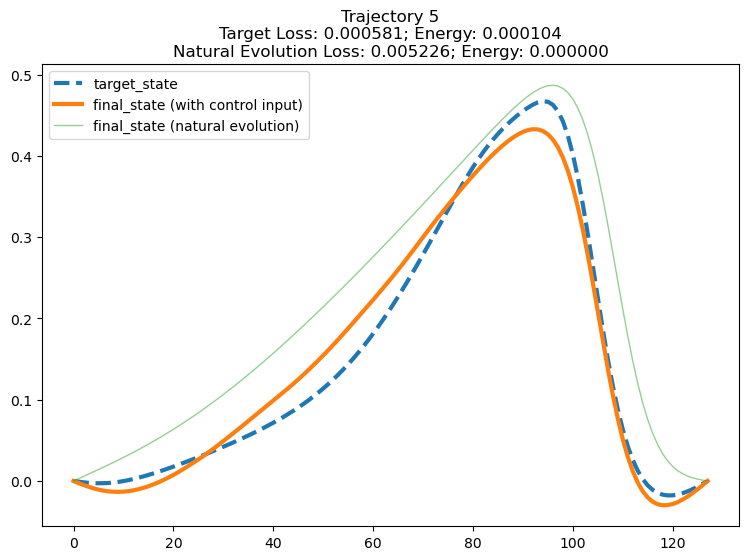

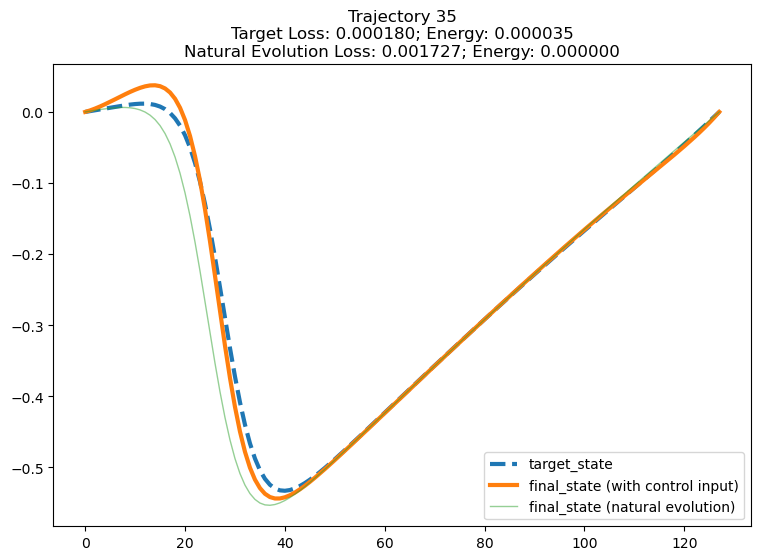

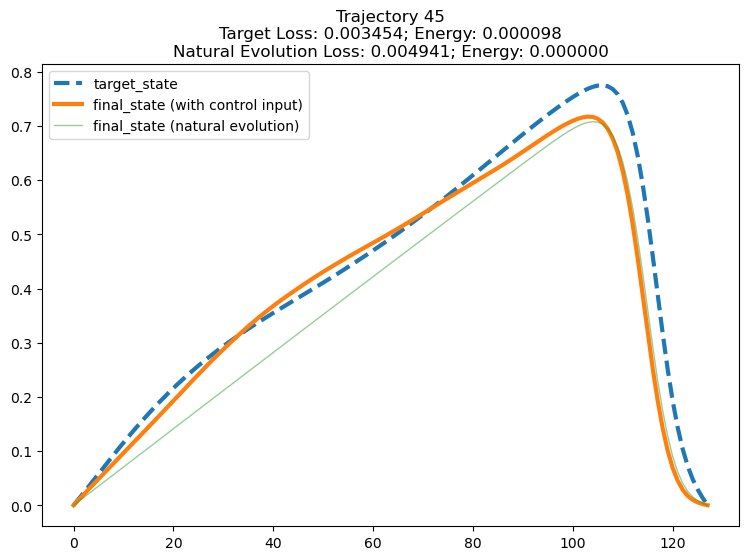

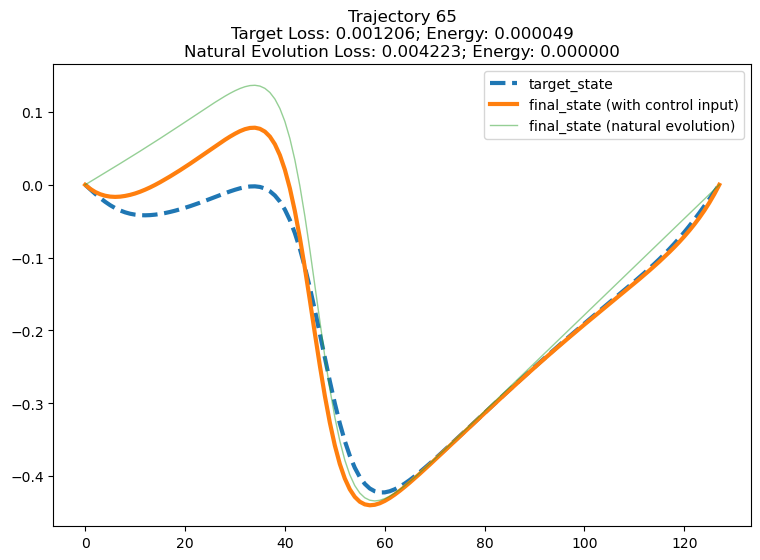

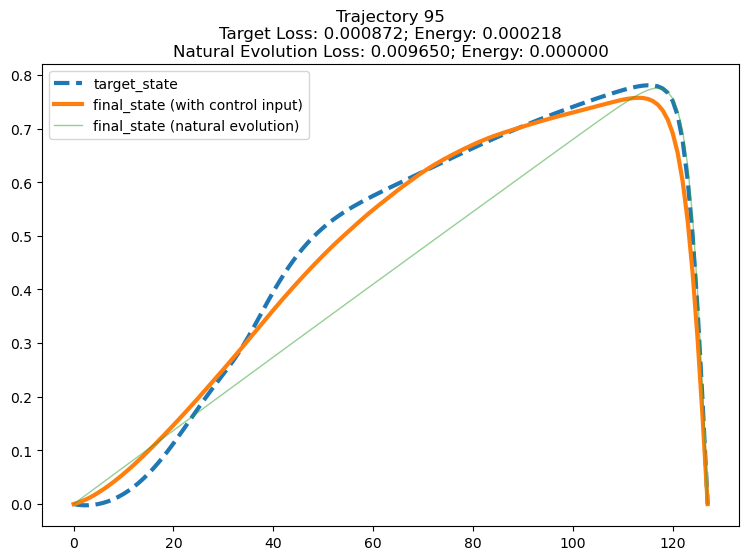

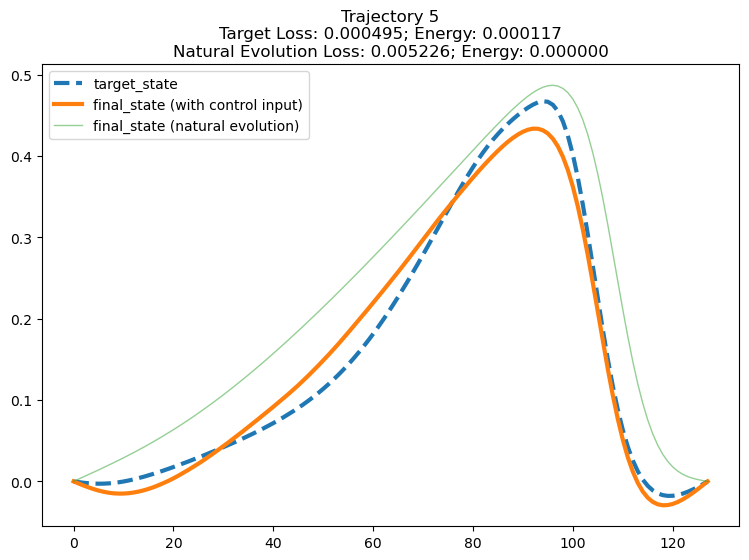

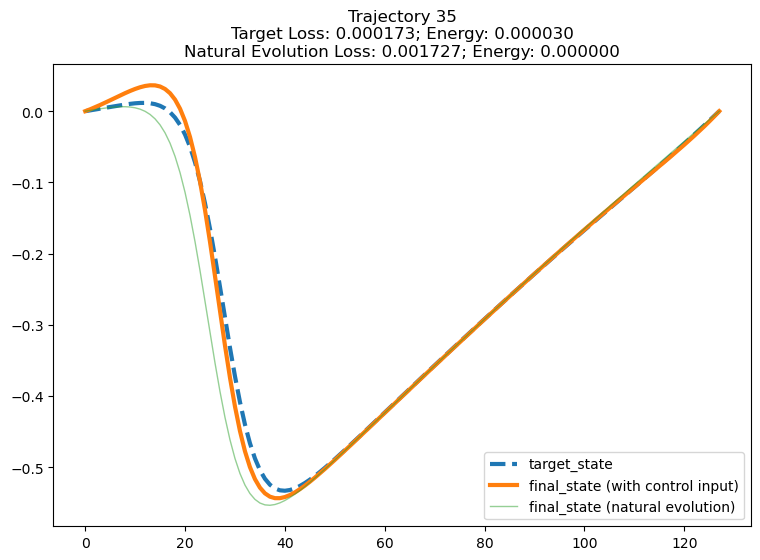

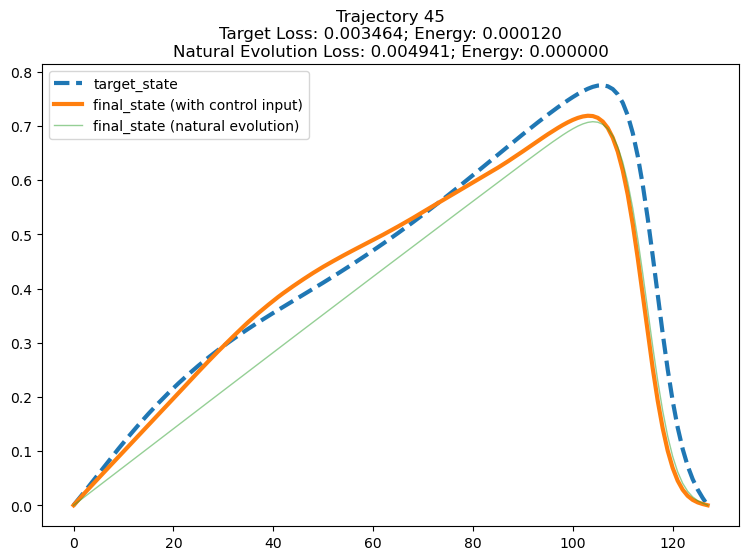

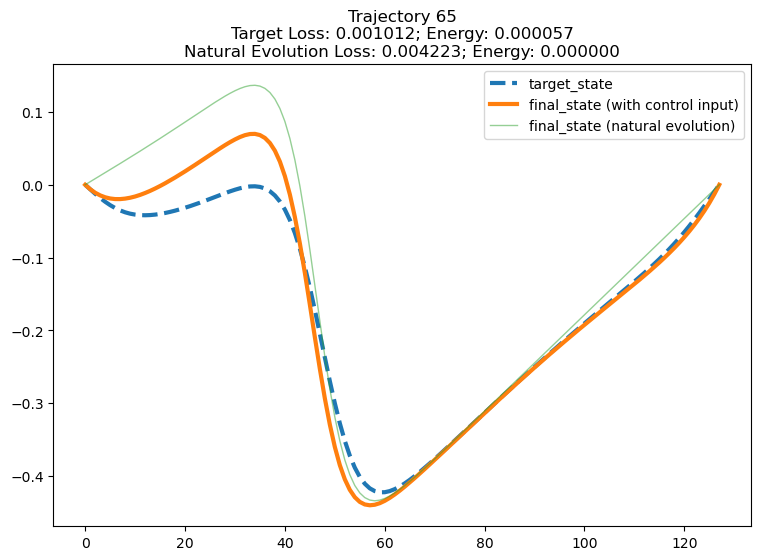

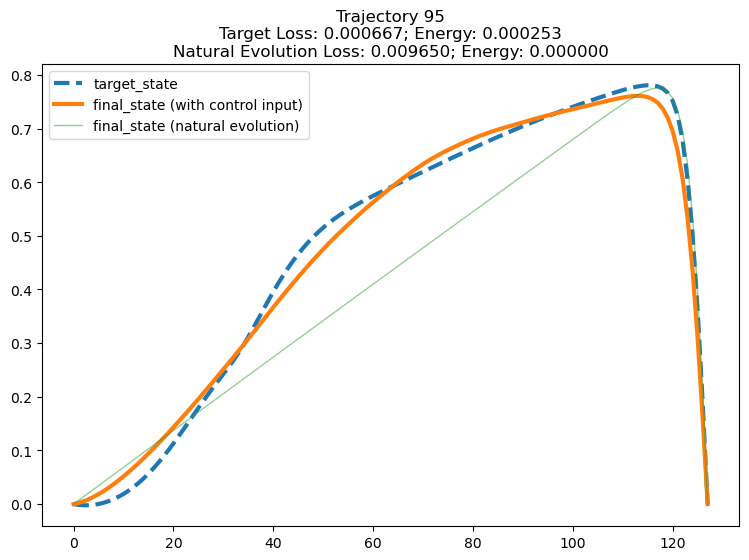

In [14]:
from generate_burgers import burgers_update

test_burgers_data_dict=pickle.load(open('data123\\burgers_100_10_128_1735572331.pkl', 'rb'))

'''
data_idx=0
plt.figure()
plt.title(f"Burgers Data Visulization on trajectory {data_idx}")
plt.plot(test_burgers_data_dict['observations'][data_idx][0], label='Timestep 0')
plt.plot(test_burgers_data_dict['observations'][data_idx][1], label='Timestep 1')
plt.plot(test_burgers_data_dict['observations'][data_idx][2], label='Timestep 2')
plt.plot(test_burgers_data_dict['observations'][data_idx][3], label='Timestep 3')
plt.plot(test_burgers_data_dict['observations'][data_idx][4], label='Timestep 4')
plt.plot(test_burgers_data_dict['observations'][data_idx][5], label='Timestep 5')
plt.plot(test_burgers_data_dict['observations'][data_idx][6], label='Timestep 6')
plt.plot(test_burgers_data_dict['observations'][data_idx][7], label='Timestep 7')
plt.plot(test_burgers_data_dict['observations'][data_idx][8], label='Timestep 8')
plt.plot(test_burgers_data_dict['observations'][data_idx][9], label='Timestep 9')
plt.legend()
plt.show()
'''


def evolve(model, initial_state, target_state, with_control=True):
    '''
    Return the final state vector given initial state vector, with or without control input.
    If with_control is False, the model will be evaluated without control input, i.e., natural evolution.
    '''
    global state_dim, action_dim, dx, dt, device
    assert initial_state.shape == target_state.shape == (state_dim,)
    s=initial_state # (state_dim,), the state vector (original meaning)
    S=np.concatenate((initial_state, target_state, np.array([0]))) # (state_dim*2+1,), the concatenated state vector (with target state and time step)
    if with_control: # The normal case
        actions=[] # A list to store the actions
        for i in range(nt): # Loop over time steps to update the state vector    
            if i%t_sample_interval==0: # Update the action every t_sample_interval time steps (every 1000 time steps)
                a = model.select_action(torch.FloatTensor(S).unsqueeze(0).to(device), is_sample=False).cpu().data.numpy().flatten()
                actions.append(a)
            s=burgers_update(s,a,dx,dt)
            S=np.concatenate((s,target_state,np.array([i//t_sample_interval]))) # Update the concatenated state vector
        energy=np.sum([(a**2).mean()*dt*nt1 for a in actions]) # J(u)=int_0^T u^2 du, the total energy of the control input
    else: # If we want to evolve the initial state without any control input. This is a baseline.
        a=np.zeros(action_dim) # Set the control input to 0, for all time steps
        for i in range(nt): # Loop over time steps to update the state vector
            s=burgers_update(s,a,dx,dt)
            S=np.concatenate((s,target_state,np.array([i//t_sample_interval]))) # Update the concatenated state vector
        energy=0
    return s, energy # final state, (state_dim,); energy, scalar


def plot_state(model, data_dict, traj_index):
    '''
    Plot the final states
    '''
    assert traj_index<data_dict['observations'].shape[0], 'traj_index out of range'
    initial_state = data_dict['observations'][traj_index][0] # (state_dim,)
    target_state = data_dict['Y_f'][traj_index] # (state_dim,)
    final_state, energy = evolve(model, initial_state=initial_state, target_state=target_state) # (state_dim,)
    final_state_, energy_  = evolve(model, initial_state=initial_state, target_state=target_state, with_control=False) # (state_dim,)

    plt.figure(figsize=(9,6))
    #plt.plot(initial_state, label='initial_state')
    plt.plot(target_state, label='target_state', lw=3, linestyle='--')
    plt.plot(final_state, label='final_state (with control input)', lw=3)
    plt.plot(final_state_, label='final_state (natural evolution)', alpha=0.5, lw=1)
    plt.title('Trajectory {}\nTarget Loss: {:.6f}; Energy: {:.6f}\nNatural Evolution Loss: {:.6f}; Energy: {:.6f}'.format(
                    traj_index,
                    ((final_state-target_state)**2).mean(),
                    energy,
                    ((final_state_-target_state)**2).mean(),
                    energy_))
    plt.legend()
    plt.show()

plot_state(model=bppo, data_dict=test_burgers_data_dict, traj_index=5)
plot_state(model=bppo, data_dict=test_burgers_data_dict, traj_index=35)
plot_state(model=bppo, data_dict=test_burgers_data_dict, traj_index=45)
plot_state(model=bppo, data_dict=test_burgers_data_dict, traj_index=65)
plot_state(model=bppo, data_dict=test_burgers_data_dict, traj_index=95)
plot_state(model=bc, data_dict=test_burgers_data_dict, traj_index=5)
plot_state(model=bc, data_dict=test_burgers_data_dict, traj_index=35)
plot_state(model=bc, data_dict=test_burgers_data_dict, traj_index=45)
plot_state(model=bc, data_dict=test_burgers_data_dict, traj_index=65)
plot_state(model=bc, data_dict=test_burgers_data_dict, traj_index=95)

In [29]:
def evaluate_target_loss_and_energy(model, data_dict):
    final_losses=[]
    final_losses_=[]
    energys=[]
    for i in tqdm.tqdm(range(len(data_dict['observations'])), desc='Looping over trajectories'):
        initial_state = test_burgers_data_dict['observations'][i][0] # (state_dim,)
        target_state = test_burgers_data_dict['Y_f'][i] # (state_dim,)
        final_state, energy=evolve(model, initial_state, target_state, with_control=True)
        final_state_, _=evolve(model, initial_state, target_state, with_control=False)
        final_losses.append(np.mean(np.square(final_state-target_state)))
        energys.append(energy)
        final_losses_.append(np.mean(np.square(final_state_-target_state)))
    return (np.mean(final_losses), np.mean(energys)),\
            (np.mean(final_losses_), 0.0)

(bppo_target_loss, bppo_energy), (natural_target_loss, natural_energy) = evaluate_target_loss_and_energy(bppo, test_burgers_data_dict)
print(f"BPPO target loss: {bppo_target_loss:8f}, Energy: {bppo_energy:8f}")
print(f"Natural target loss: {natural_target_loss:8f}, Energy: {natural_energy:8f}")

Looping over trajectories: 100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

BPPO target loss: 0.0010029461558851605, Energy: 8.138451182675454e-05
Natural target loss: 0.004849128535548501, Energy: 0.0


In [30]:
(bc_target_loss, bc_energy), (natural_target_loss, natural_energy) = evaluate_target_loss_and_energy(bc, test_burgers_data_dict)
print(f"BC target loss: {bc_target_loss:8f}, Energy: {bc_energy:8f}")
print(f"Natural target loss: {natural_target_loss:8f}, Energy: {natural_energy:8f}")

Looping over trajectories: 100%|██████████| 100/100 [02:11<00:00,  1.32s/it]

BC target loss: 0.0010029461558851605, Energy: 8.138451182675454e-05
Natural target loss: 0.004849128535548501, Energy: 0.0
